# Model logitowy

(Estymacja regresji logistycznej)

#### Dane: 
- choroby serca 
- z Kaggle

#### Zmienna objaśniana: 
- CHD - Congenital Heart Disease/Defect
- TenYearCHD - CHD w ciągu 10 lat

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
import os
import progressbar
# py -m pip install progressbar2
# py -m pip install openpyxl
# py -m pip install statsmodels
# py -m pip install seaborn
import openpyxl as xl
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.discrete.discrete_model import Logit
import statsmodels.tools as my_tools

In [43]:
### wczytanie danych

mydata = pd.read_csv('framingham.csv')

# zmieniamy nazwę zmiennej objaśnianej z 'TenYearCHD' na 'Dependent_CHD' (jest to ostatnia zmienna w tym zbiorze danych)
mydata.rename(columns = {'TenYearCHD':'Dependent_CHD'}, inplace = True)
mydata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  Dependent_CHD    4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


### Pozbycie się missing values

In [44]:
mydata.isnull().sum().sort_values(ascending = False)

### usuwamy rekordy w pełni puste
mydata.dropna(how = 'all', inplace = True)
mydata.isnull().sum().sort_values(ascending = False)
# wniosek --> nie ma pustych rekordów, wszystkie są przynajmniej częściowo pełne

### usuwamy niepełne rekordy ze zbioru:

# 1) lokalizujemy indeksy takich rekordów
ids_with_nan = mydata[mydata.isna().any(axis = 1)]
print('Liczba rekordów częściowo pustych:', ids_with_nan.shape[0])

# 2) usuwamy takie rekordy
mydata_f = mydata.dropna()
mydata_f.info()

Liczba rekordów częściowo pustych: 582
<class 'pandas.core.frame.DataFrame'>
Index: 3656 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3656 non-null   int64  
 1   age              3656 non-null   int64  
 2   education        3656 non-null   float64
 3   currentSmoker    3656 non-null   int64  
 4   cigsPerDay       3656 non-null   float64
 5   BPMeds           3656 non-null   float64
 6   prevalentStroke  3656 non-null   int64  
 7   prevalentHyp     3656 non-null   int64  
 8   diabetes         3656 non-null   int64  
 9   totChol          3656 non-null   float64
 10  sysBP            3656 non-null   float64
 11  diaBP            3656 non-null   float64
 12  BMI              3656 non-null   float64
 13  heartRate        3656 non-null   float64
 14  glucose          3656 non-null   float64
 15  Dependent_CHD    3656 non-null   int64  
dtypes: float64(9), int64(7)
me

## To do list:
1. transformacja zmiennej BMI
2. 'szybka' analiza skupień
3. kilka statystyk dla zmiennych
4. regresja logistyczna

#### Ad. 1 (transformacja zmiennej BMI):
- wartości optymalne BMI to: 18.5 - 24.9

Jeżeli BMI jest z przedziału 18.5 - 24.9, to new_BMI = 0
Jeżeli BMI < 18.5, to new_BMI = 18.5 - BMI
Jeżeli BMI > 24.9, to new_BMI = BMI - 24.9

In [45]:
tmp = pd.DataFrame([18.5 - bmi if bmi < 18.5 
                    else bmi - 24.9 if bmi > 24.9 
                    else 0 for bmi in mydata_f['BMI']], 
                    columns = ['BMI'], index = mydata_f.index)
tmp.head()

#podmiana danych w kolumnie
mydata_f = mydata_f.assign(BMI = tmp['BMI'])
mydata_f.describe().map('{:,.2f}'.format)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Dependent_CHD
count,"3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00","3,656.00"
mean,0.44,49.56,1.98,0.49,9.02,0.03,0.01,0.31,0.03,236.87,132.37,82.91,2.00,75.73,81.86,0.15
std,0.50,8.56,1.02,0.50,11.92,0.17,0.08,0.46,0.16,44.10,22.09,11.97,3.02,11.98,23.91,0.36
min,0.00,32.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,113.00,83.50,48.00,0.00,44.00,40.00,0.00
25%,0.00,42.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,75.00,0.00,68.00,71.00,0.00
50%,0.00,49.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,234.00,128.00,82.00,0.56,75.00,78.00,0.00
75%,1.00,56.00,3.00,1.00,20.00,0.00,0.00,1.00,0.00,263.25,144.00,90.00,3.14,82.00,87.00,0.00
max,1.00,70.00,4.00,1.00,70.00,1.00,1.00,1.00,1.00,600.00,295.00,142.50,31.90,143.00,394.00,1.00


#### Ad. 2 ('szybka' analiza skupień - cluster analysis)

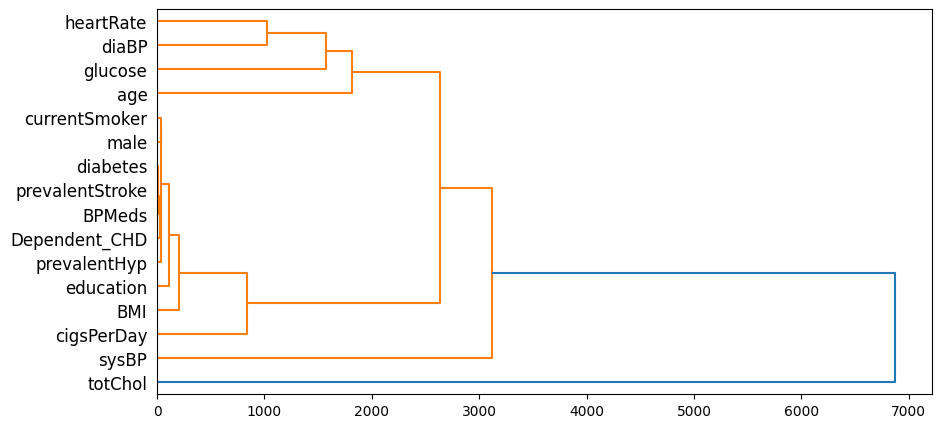

In [46]:
d_tr = mydata_f.T.values   # d-tree
linked_data = linkage(d_tr, method = 'single', metric = 'euclidean')

plt.rc('figure', figsize = (10,5))
dendrogram(linked_data, orientation = 'right', labels = mydata_f.columns)
plt.show()

#### Ad. 3 (statystyki dla zmiennych)

In [47]:
# dzielenie zbioru na zmienne jakościowe i ilościowe
mydata_qnt = mydata_f[['Dependent_CHD', 'age', 'education', 'cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]   #quantity
mydata_qlt = mydata_f[['Dependent_CHD', 'male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'diabetes']]   #quality

mydata_qlt.describe()

,Dependent_CHD,male,currentSmoker,BPMeds,prevalentStroke,diabetes
count,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000
mean,0.152352,0.443654,0.489059,0.030361,0.005744,0.027079
std,0.359411,0.496883,0.499949,0.171602,0.075581,0.162335
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


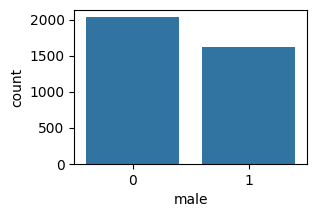

In [48]:
plt.figure(figsize = (3,2))
MyCountPlot = sb.countplot(x = mydata_qlt.male)
plt.xticks(horizontalalignment = 'center')
plt.show()

#kobiety częściej

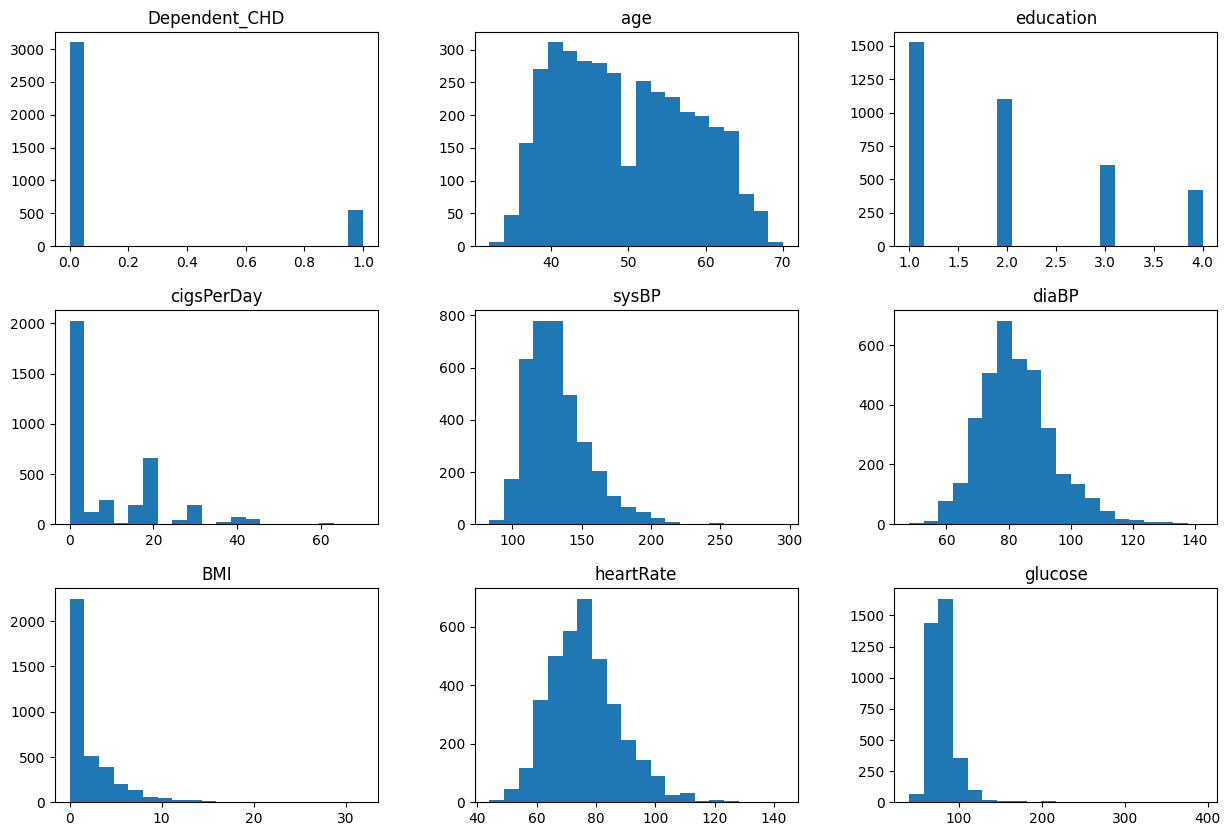

In [49]:
# histogramy
mydata_qnt.hist(grid = False, figsize = (15,10), bins = 20);    #średnik jest po to, żeby nie wyświetlały się informacje z pamięci, a same histogramy

In [50]:
#korelacje
mydata_qnt.corr('pearson').map('{:,.2f}'.format)  #do wyboru: pearson, spearman, kendall

,Dependent_CHD,age,education,cigsPerDay,sysBP,diaBP,BMI,heartRate,glucose
Dependent_CHD,1.00,0.23,-0.06,0.05,0.22,0.15,0.08,0.02,0.12
age,0.23,1.00,-0.16,-0.19,0.39,0.21,0.11,-0.00,0.12
education,-0.06,-0.16,1.00,0.01,-0.12,-0.06,-0.15,-0.06,-0.03
cigsPerDay,0.05,-0.19,0.01,1.00,-0.09,-0.06,-0.08,0.06,-0.05
sysBP,0.22,0.39,-0.12,-0.09,1.00,0.79,0.31,0.18,0.13
diaBP,0.15,0.21,-0.06,-0.06,0.79,1.00,0.36,0.18,0.06
BMI,0.08,0.11,-0.15,-0.08,0.31,0.36,1.00,0.09,0.09
heartRate,0.02,-0.00,-0.06,0.06,0.18,0.18,0.09,1.00,0.10
glucose,0.12,0.12,-0.03,-0.05,0.13,0.06,0.09,0.10,1.00


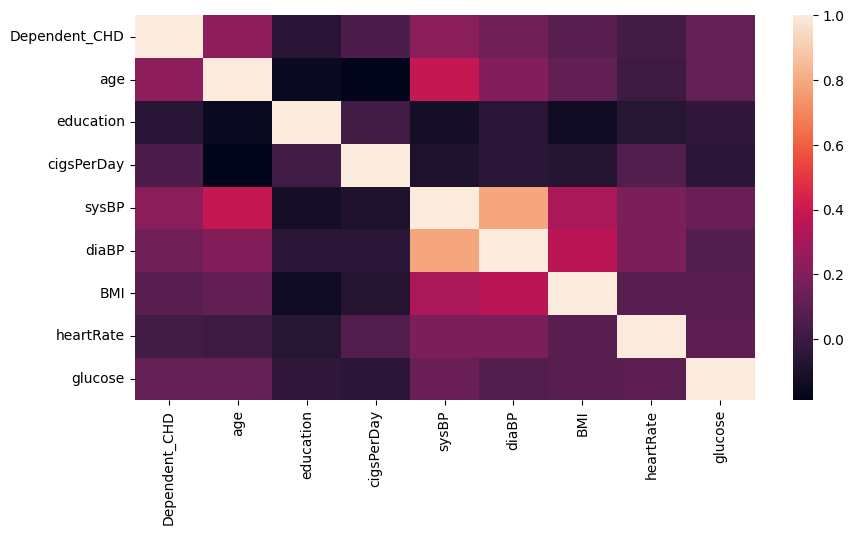

In [51]:
#heatmapa
sb.heatmap(mydata_qnt.corr('pearson'));

#### Ad. 4 (regresja logistyczna - regresja modeli logitowych)
Model logitowy estymuje metodą największej wiarygodności

In [52]:
#estymacja modeli logitowych

y = mydata_f['Dependent_CHD']
lg0 = Logit(y, my_tools.add_constant(mydata_f.iloc[:, 0:-1])).fit()      #model bazowy ze wszystkimi zmiennymi i stałą; metoda 'fit' estymuje model automatycznie (?)

lg0.summary()

Optimization terminated successfully.
         Current function value: 0.376505
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Dependent_CHD   No. Observations:                 3656
Model:                          Logit   Df Residuals:                     3640
Method:                           MLE   Df Model:                           15
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.1178
Time:                        14:33:29   Log-Likelihood:                -1376.5
converged:                       True   LL-Null:                       -1560.3
Covariance Type:            nonrobust   LLR p-value:                 4.514e-69
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.1554      0.673    -12.124      0.000      -9.474      -6.837
male                0.5630      0.109      5.156      0.000       0.349       0.777
age                 0.0636      0.007      9.521      0.000       0.051       0.077
education          -0.0426      0.049     -0.862      0.389      -0.140       0.054
currentSmoker       0.0791      0.156      0.506      0.613      -0.227       0.386
cigsPerDay          0.0177      0.006      2.846      0.004       0.006       0.030
BPMeds              0.1569      0.235      0.669      0.504      -0.303       0.617
prevalentStroke     0.6744      0.491      1.373      0.170      -0.288       1.637
prevalentHyp        0.2304      0.138      1.669      0.095      -0.040       0.501
diabetes            0.0214      0.316      0.068      0.946      -0.598       0.641
totChol             0.0024      0.001      2.099      0.036       0.000       0.005
sysBP               0.0154      0.004      4.052      0.000       0.008       0.023
diaBP              -0.0049      0.006     -0.765      0.444      -0.018       0.008
BMI                 0.0193      0.016      1.217      0.224      -0.012       0.050
heartRate          -0.0033      0.004     -0.790      0.430      -0.012       0.005
glucose             0.0071      0.002      3.181      0.001       0.003       0.011
===================================================================================
"""

In [53]:
#model 1 z kilkoma zmiennymi i stałą
lg1 = Logit(y, my_tools.add_constant(mydata_f[['male', 'age', 'cigsPerDay', 'prevalentHyp', 'sysBP', 'glucose', 'BMI']])).fit()

#model 2 z jeszcze mniejszą liczbą zmiennych i stałą
lg2 = Logit(y, my_tools.add_constant(mydata_f[['male', 'age', 'cigsPerDay', 'sysBP', 'glucose']])).fit()

lg1.summary()

Optimization terminated successfully.
         Current function value: 0.377737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378354
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Dependent_CHD   No. Observations:                 3656
Model:                          Logit   Df Residuals:                     3648
Method:                           MLE   Df Model:                            7
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.1149
Time:                        14:33:29   Log-Likelihood:                -1381.0
converged:                       True   LL-Null:                       -1560.3
Covariance Type:            nonrobust   LLR p-value:                 1.854e-73
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -8.2967      0.472    -17.563      0.000      -9.223      -7.371
male             0.5266      0.106      4.978      0.000       0.319       0.734
age              0.0672      0.006     10.517      0.000       0.055       0.080
cigsPerDay       0.0199      0.004      4.767      0.000       0.012       0.028
prevalentHyp     0.2247      0.135      1.658      0.097      -0.041       0.490
sysBP            0.0141      0.003      4.902      0.000       0.008       0.020
glucose          0.0072      0.002      4.316      0.000       0.004       0.010
BMI              0.0182      0.015      1.196      0.232      -0.012       0.048
================================================================================
"""

In [54]:
lg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Dependent_CHD   No. Observations:                 3656
Model:                          Logit   Df Residuals:                     3650
Method:                           MLE   Df Model:                            5
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.1134
Time:                        14:33:29   Log-Likelihood:                -1383.3
converged:                       True   LL-Null:                       -1560.3
Covariance Type:            nonrobust   LLR p-value:                 2.411e-74
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7040      0.421    -20.673      0.000      -9.529      -7.879
male           0.5311      0.106      5.030      0.000       0.324       0.738
age            0.0673      0.006     10.559      0.000       0.055       0.080
cigsPerDay     0.0195      0.004      4.681      0.000       0.011       0.028
sysBP          0.0180      0.002      8.417      0.000       0.014       0.022
glucose        0.0073      0.002      4.367      0.000       0.004       0.011
==============================================================================
"""

In [55]:
#porównanie wyników
print('BIC')
print('Model 0: ', lg0.bic)
print('Model 1: ', lg1.bic)
print('Model 2: ', lg2.bic, '\n')

#wg. kryterium Shwarza najlepszy jest model 2

print('AIC')
print('Model 0: ', lg0.aic)
print('Model 1: ', lg1.aic)
print('Model 2: ', lg2.aic)

#wg. AIC najlepszy jest model 1

BIC
Model 0:  2884.2694810843445
Model 1:  2827.64668255958
Model 2:  2815.7519176563674 

AIC
Model 0:  2785.00348216316
Model 1:  2778.0136830989877
Model 2:  2778.527168060923
